In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, pearsonr, spearmanr
from sklearn.metrics import confusion_matrix
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
df = pd.read_csv('preprocess data/FullDataPart3.csv')
# convert labels to number
df['label'] = df['label'].apply(lambda l: str(l).replace('. Not guilty', '').replace('. Slightly guilty', '').replace('. Very guilty', '').replace('. Completely guilty', ''))
# Convert example id to original-form example id
df['example_id'] = df['example_id'].apply(lambda id: int(id.split('_')[0]))
# Load original Data
df_org = pd.read_csv('./preprocess data/data_team3 - DIFU.csv')[['example_id', 'batch', 'topic', 'type']]
# join all the information from the original data (e.g. topic)
df = df.join(df_org, on='example_id', how='inner', lsuffix='l_')[['text', 'label', 'batch', 'topic', 'type', 'example_id']]

In [50]:
def get_height(values):
    heigths = {'1': 0, '2': 0, '3': 0, '4': 0}
    for v in values:
        heigths[v] += 1
    return heigths

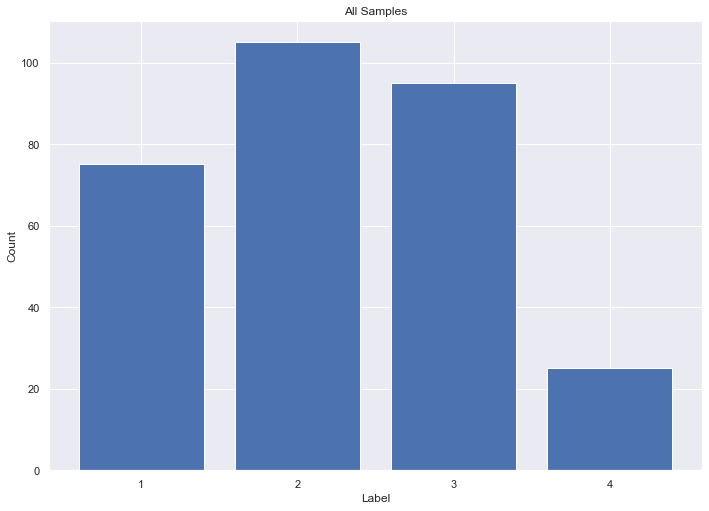

In [57]:
values = df['label'].values
hist = get_height(values)

# Plot the bar chart with the rearranged categories
plt.bar(hist.keys(), hist.values())

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('All Samples')

# Display the plot
plt.show()

In [3]:
tldr_labels = []
fullstory_labels = []
for id in df['example_id'].unique():
    tldr_label = df[(df['example_id'] == id) & (df['type'] == 'tldr')]
    fullstory_label = df[(df['example_id'] == id) & (df['type'] == 'documents')]
    tldr_labels.append(tldr_label)
    fullstory_labels.append(fullstory_label)

In [33]:
def compute_correlation(df, annotator1_name, annotator2_name, round_units=3):

    df1 = df[f"{annotator1_name}_numeric_label"]
    df2 = df[f"{annotator2_name}_numeric_label"]
    # Compute Kendall's tau
    tau, _ = kendalltau(df1, df2)

    # Compute Pearson correlation
    r, _ = pearsonr(df1, df2)

    # Compute Spearman correlation
    rho, _ = spearmanr(df1, df2)
    # print annotator names and the three correlations in one print statement
    print(f'{annotator1_name} and {annotator2_name} have Kendall\'s tau of {round(tau,round_units)}, Pearson correlation of {round(r,round_units)}, and Spearman correlation of {round(rho,round_units)}.')

def compute_confusion(df, annotator1_name, annotator2_name, data_type, annonimuous=True):
    df1 = df[f"{annotator1_name}_numeric_label"]
    df2 = df[f"{annotator2_name}_numeric_label"]
    # Compute confusion matrix
    cm = confusion_matrix(y_true=df1, y_pred=df2)
    # number unique labels
    num_labels = df1.nunique()
    # Define labels for the confusion matrix
    if num_labels == 5:
        labels = ['Not Guilty', 'Slightly Guilty', 'Moderately Guilty', 'Very Guilty', 'Completely Guilty']
    elif num_labels == 4:
        labels = ['Not Guilty', 'Slightly Guilty', 'Very Guilty', 'Completely Guilty']
        
    # Plot confusion matrix as heatmap
    s = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
    xticklabels=labels, yticklabels=labels)
    # Add x axis label
    s.set_xlabel(annotator1_name if not annonimuous else 'Annotator 1')
    # Add y axis label
    s.set_ylabel(annotator2_name if not annonimuous else 'Annotator 2')
    s.set_title(f'Confusion Matrix - {data_type}')
    plt.tight_layout()
    # Show plot
    plt.savefig('confusion_matrix.png')
    plt.show()

def load_and_process(path1, path2, annotator1_name, annotator2_name, split_id):
        df1 = pd.read_csv(path1)
        df2 = pd.read_csv(path2)
        # Concatenate columns
        df = pd.concat([df1, df2], keys=[annotator1_name, annotator2_name], axis=1)
        df = df.dropna()
        # split label column into two columns based on the first character
        for annotator_name in [annotator1_name, annotator2_name]:
            try:
                df[(annotator_name,'numeric_label')] = df[(annotator_name,'label')].str[0].astype(int)
            except AttributeError:
                df[(annotator_name,'numeric_label')] = df[(annotator_name,'label')].astype(int)

        df.columns = ['_'.join(col) for col in df.columns.values]
        df.rename(columns={f'{annotator1_name}_example_id': 'example_id'}, inplace=True)
        if split_id:
            df[['base_example_id', 'type', 'topic']] = df['example_id'].str.split('_', expand=True)
        return df

In [34]:
ANNOT1 = 'Papo'
ANNOT2 = 'Sahar'
sht_full = load_and_process(path1=f'preprocess data\DataPart3_{ANNOT1}.csv', 
                                path2=f'preprocess data\DataPart3_{ANNOT2}.csv',
                                annotator1_name=ANNOT1, annotator2_name=ANNOT2, split_id=False)

Full story + TL;DR
Papo and Sahar have Kendall's tau of 0.142, Pearson correlation of 0.162, and Spearman correlation of 0.162.


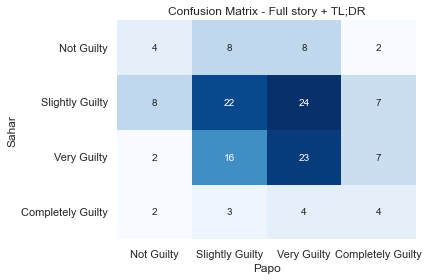

In [35]:
for data_type, data_type_name in zip([sht_full], ['Full story + TL;DR']):
        print(data_type_name)

        compute_correlation(data_type, annotator1_name=ANNOT1, annotator2_name=ANNOT2)
        compute_confusion(data_type,  annotator1_name=ANNOT1, annotator2_name=ANNOT2, data_type=data_type_name, annonimuous=False)